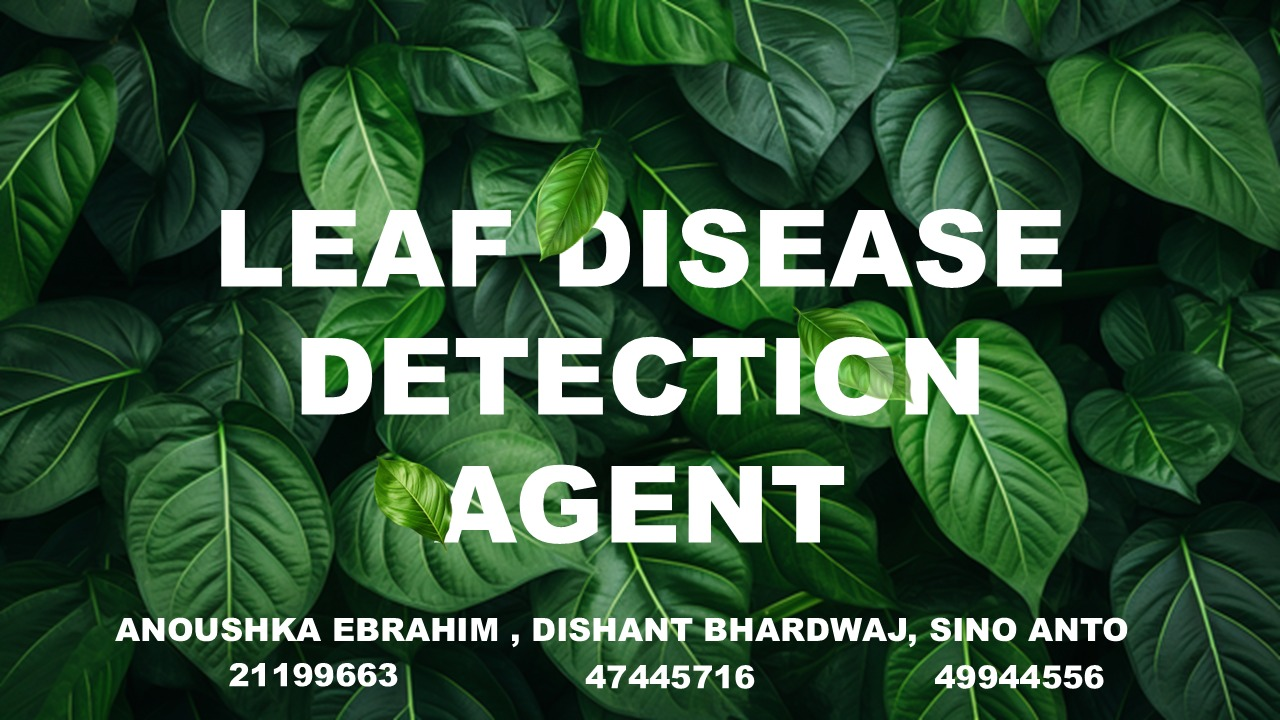


# TITLE - LEAF DISEASE DETECTION AGENT 🍀🕵️

### 📍PROBLEM STATEMENT  
People often struggle to detect and treat plant diseases early. Manual inspection is time-consuming, error-prone, and not scalable. An AI system that uses image input from a phone or webcam and gives disease diagnosis with highlighted infected areas can significantly help in early intervention and improve crop health.

### 📍OUR OBJECTIVE 
To build an end-to-end intelligent system that can:

1. Classify the plant type (e.g., potato, tomato, bell pepper)

2. Detect whether the leaf is healthy or infected

3. Identify infected regions using bounding boxes on the leaf image,

4. Work on real-world images with different backgrounds (not just lab-type clean backgrounds)


### 📍HOW WILL IT WORK?
1. Input: Leaf image (from camera, phone, or uploaded photo)

2. Output:

Plant type (potato/tomato/etc.)

Health status (healthy / disease name)

Disease bounding boxes drawn on infected areas (via YOLOv8)


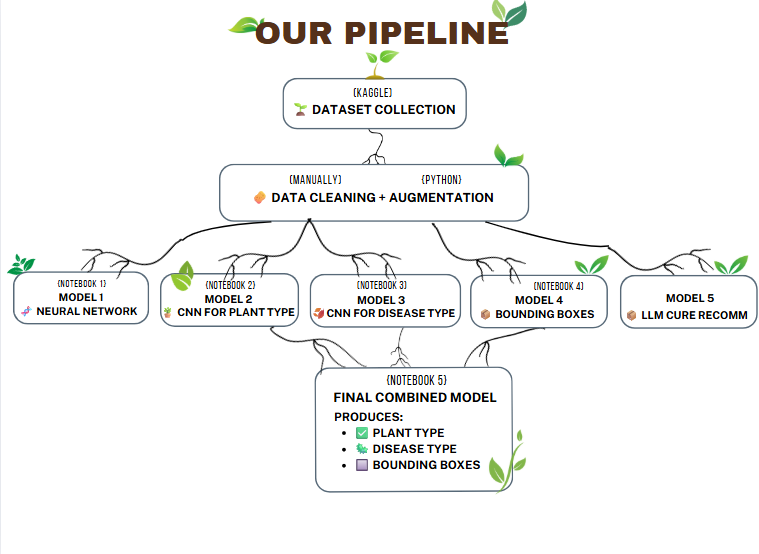
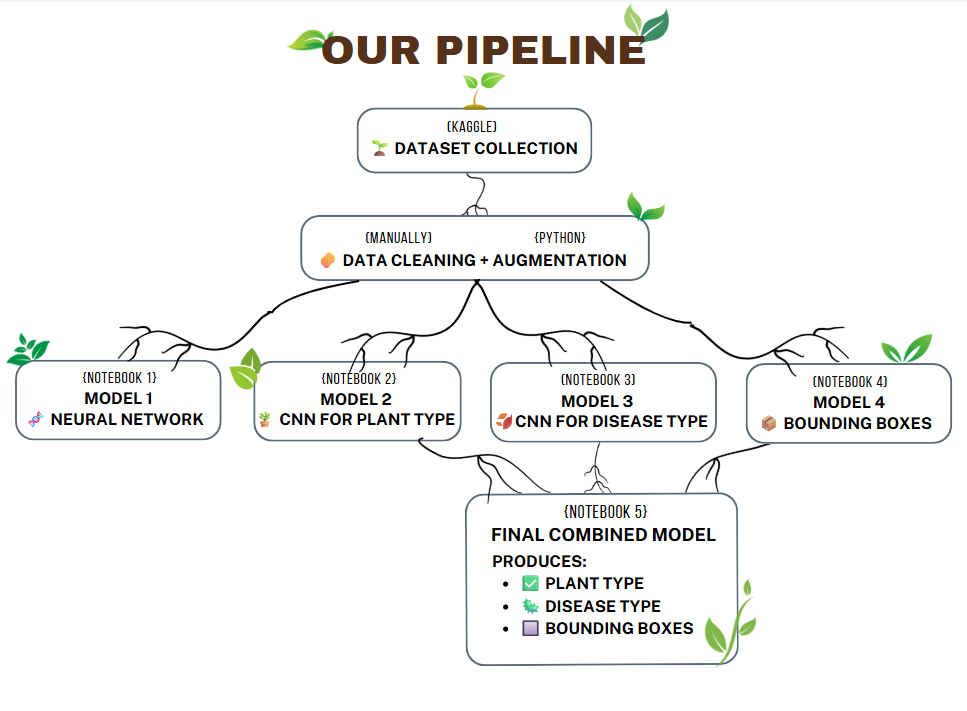
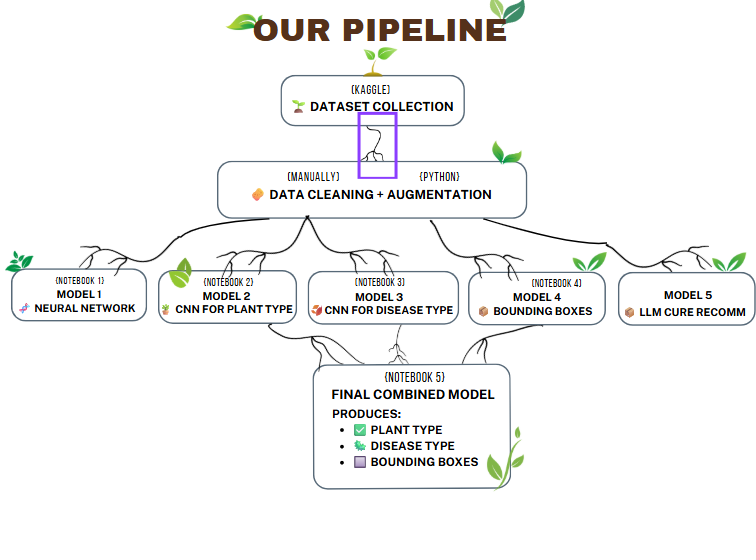

### ⚙️OUR DATASET - https://www.kaggle.com/datasets/emmarex/plantdisease

### STEPS THAT WE HAVE FOLLOWED AND MODELS THAT WE HAVE CHOSEN- 

**🔢 Model 1: Neural Network (Baseline Classifier)**
Purpose: To compare model performance using a simple, fully connected neural network.
Use: Served as a benchmark to evaluate the effectiveness of CNN-based approaches.

**🧠 Model 2: CNN to Detect Plant Type**
Purpose: To classify the plant type (e.g., Potato, Tomato, Bell Pepper).
Output: Predicted plant type (multi-class classification).

Notes:
This model helps in the first step of the pipeline, identifying which crop the leaf belongs to before checking for disease.

**🦠 Model 3: CNN to Detect Disease Type**
Purpose: To classify the type of disease affecting the plant.
Output: Predicted disease class (e.g., Early Blight, Late Blight, Healthy).

Notes:
Works after plant classification, helping to understand specific problems in the crop.
Trained on multiple classes like Potato___Early_blight, Tomato___Leaf_Mold, etc.

**📦 Model 4: YOLOv8 for Object Detection**
Purpose: To detect and localize infected regions in the leaf using bounding boxes.
Output: Bounding box predictions labeled as "infected".

Notes:
Trained using Manually created custom dataset from Roboflow with only one class: infected.



## Tools Used ⚙️
⛏️**Kaggle**	Neural Network & Bounding Boxes

⛏️**Jupyter Notebook**	CNN model training & integration

⛏️**Roboflow**	Bounding box annotation

⛏️**Ultralytics YOLOv8**	Object detection

⛏️**Python Libraries**	tensorflow, torch, opencv, matplotlib, albumentations, seaborn


# NEURAL NETWORK

# MODEL 1 : NEURAL NETWORK

## 🌱 PlantVillage Neural Network using Neural Networks

---

### STEP 1: Importing the libraries

---

In [1]:
import numpy as np
import pandas as pd
import os
import cv2  # For image reading and resizing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input


2025-06-21 14:06:41.567668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750514801.767024      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750514801.823127      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Data Loading and Preprocessing

- **Find all images** in the PlantVillage dataset.
- **Resize** images to 64x64 pixels (small enough for a simple neural network).
- **Assign labels** (each folder is a different plant disease or healthy plant).
- **Normalize** images (convert pixel values from 0–255 to 0–1).

---


In [2]:
# ---- PATH SETUP ----
dataset_dir = '/kaggle/input/plantdisease/PlantVillage'  # Update if your dataset path is different
img_size = 64  # As per your question, images resized to 64x64

# ---- LOAD IMAGES AND LABELS ----
categories = os.listdir(dataset_dir)  # Each sub-folder is a category (disease or healthy)
X = []
y = []

for idx, category in enumerate(categories):
    category_path = os.path.join(dataset_dir, category)
    if not os.path.isdir(category_path):  # Only folders, skip files
        continue
    for file in os.listdir(category_path):
        img_path = os.path.join(category_path, file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))   # Resize to 64x64
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    # Convert to RGB color
            X.append(img)
            y.append(idx)                                 # Label as the index of the category

X = np.array(X, dtype='float32') / 255.0  # Normalize pixel values to [0, 1]
y = np.array(y)  # Labels as numbers

print("Total samples loaded:", X.shape[0])
print("Each image shape (should be 64x64x3):", X.shape[1:])


Total samples loaded: 20638
Each image shape (should be 64x64x3): (64, 64, 3)


### STEP 3. Data Splitting: Train, Validation, Test

We split the data into:
- **Training set**
- **Validation set**
- **Test set**

---

In [3]:
# ---- SPLIT INTO TRAIN AND TEST ----
# (First, split off the test set. We will split train into train/validation next.)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---- SPLIT TRAIN INTO ACTUAL TRAIN AND VALIDATION ----
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval
)

# ---- CONVERT LABELS TO ONE-HOT (for neural network training) ----
num_classes = len(categories)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

### STEP 4. Building the model

---

In [4]:
from tensorflow.keras.layers import Input

# ---- BUILD THE MODEL (Correct Style) ----
model = Sequential()
model.add(Input(shape=(img_size, img_size, 3)))   # Explicit input layer
model.add(Flatten())                              # No input_shape here!
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))


# ---- COMPILE MODEL ----
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


I0000 00:00:1750515222.634908      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


### STEP 5: Training the model

---

In [5]:
# ---- TRAIN THE MODEL ----
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20


I0000 00:00:1750515235.259482     100 service.cc:148] XLA service 0x787fc0004f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750515235.260207     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750515235.486535     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


 48/207 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0950 - loss: 3.8395

I0000 00:00:1750515236.944296     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1352 - loss: 3.0062 - val_accuracy: 0.1781 - val_loss: 2.2936
Epoch 2/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2036 - loss: 2.3878 - val_accuracy: 0.2704 - val_loss: 2.3028
Epoch 3/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2322 - loss: 2.3193 - val_accuracy: 0.2898 - val_loss: 2.1897
Epoch 4/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2493 - loss: 2.2701 - val_accuracy: 0.2671 - val_loss: 2.2259
Epoch 5/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2521 - loss: 2.2632 - val_accuracy: 0.3041 - val_loss: 2.1532
Epoch 6/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2580 - loss: 2.2063 - val_accuracy: 0.3059 - val_loss: 2.1413
Epoch 7/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2467 - loss: 2.2489 - val_accuracy: 0.3186 - val_loss: 2.1056
Epoch 8/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2718 - loss: 2.2007 - val_accuracy: 0.3486 - val

---

## 6. Visualization

---

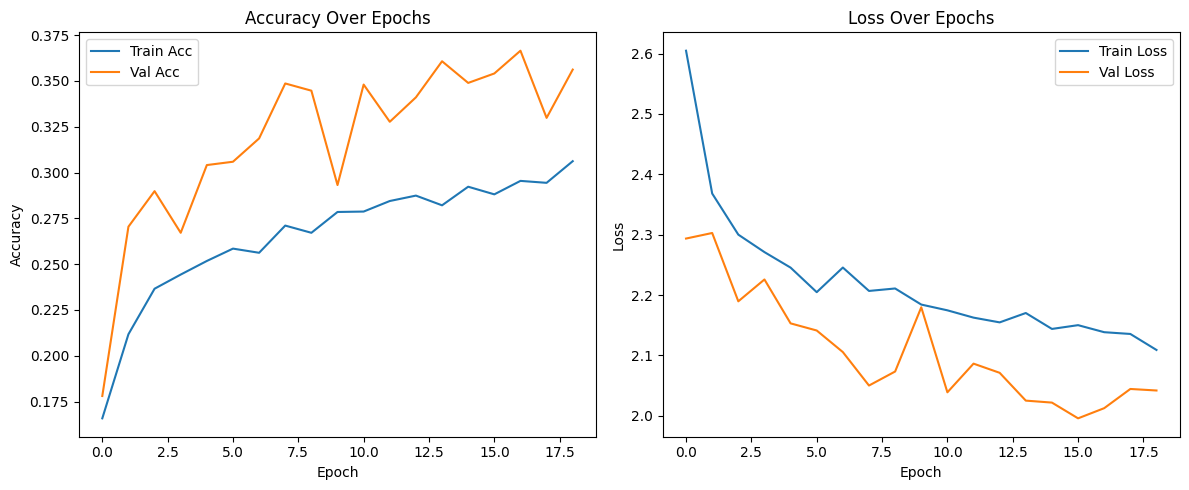

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


---
## 7. Evaluating Performance: Train, Validation, Test
---

413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report on Train Data:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.00      0.00      0.00       638
                           Potato___healthy       0.00      0.00      0.00        98
                           Tomato_Leaf_Mold       0.00      0.00      0.00       610
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.87      0.76      0.81      2053
                      Tomato_Bacterial_spot       0.19      0.92      0.31      1361
                  Tomato_Septoria_leaf_spot       0.00      0.00      0.00      1134
                             Tomato_healthy       0.28      0.86      0.42      1018
Tomato_Spider_mites_Two_spotted_spider_mite       0.65      0.47      0.55      1073
                        Tomato_Early_blight       0.00      0.00      0.00       640
                        Tomato__Target_Spot       0.22      0.05      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


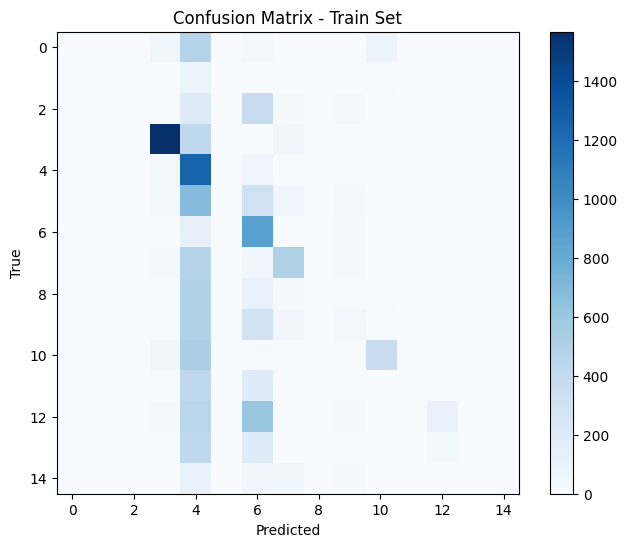

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report on Validation Data:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.00      0.00      0.00       160
                           Potato___healthy       0.00      0.00      0.00        24
                           Tomato_Leaf_Mold       0.00      0.00      0.00       152
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.87      0.75      0.80       513
                      Tomato_Bacterial_spot       0.19      0.93      0.32       340
                  Tomato_Septoria_leaf_spot       0.00      0.00      0.00       283
                             Tomato_healthy       0.28      0.85      0.42       255
Tomato_Spider_mites_Two_spotted_spider_mite       0.67      0.46      0.55       268
                        Tomato_Early_blight       0.00      0.00      0.00       160
                        Tomato__Target_Spot       0.17      0.04  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


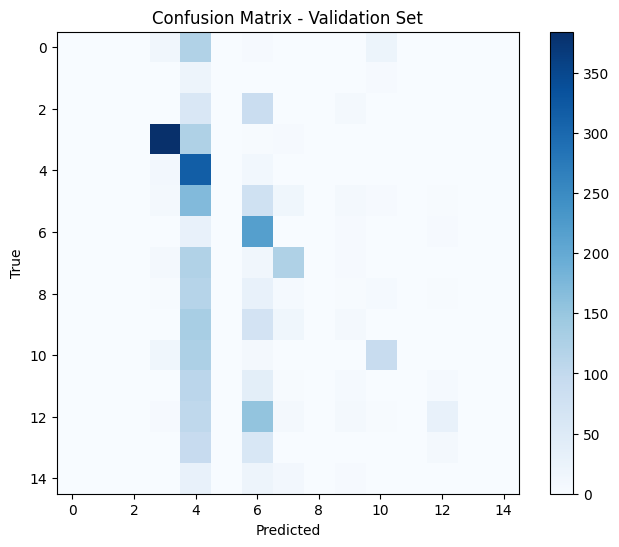

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report on Test Data:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.00      0.00      0.00       199
                           Potato___healthy       0.00      0.00      0.00        30
                           Tomato_Leaf_Mold       0.00      0.00      0.00       190
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.86      0.75      0.80       642
                      Tomato_Bacterial_spot       0.19      0.91      0.31       426
                  Tomato_Septoria_leaf_spot       0.00      0.00      0.00       354
                             Tomato_healthy       0.27      0.87      0.41       318
Tomato_Spider_mites_Two_spotted_spider_mite       0.61      0.43      0.50       335
                        Tomato_Early_blight       0.00      0.00      0.00       200
                        Tomato__Target_Spot       0.23      0.05      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


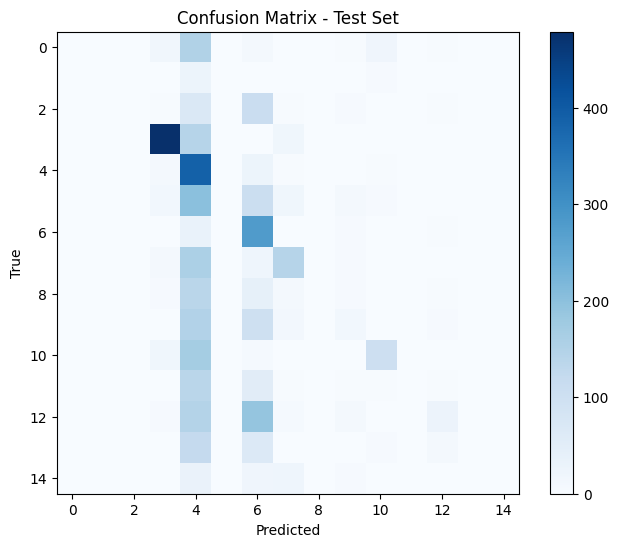

In [7]:
# ---- TRAIN SET PERFORMANCE ----
y_train_pred_probs = model.predict(X_train)
y_train_pred = np.argmax(y_train_pred_probs, axis=1)
print("Classification Report on Train Data:")
print(classification_report(y_train, y_train_pred, target_names=categories))
cm_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm_train, cmap='Blues')
plt.title("Confusion Matrix - Train Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

# ---- VALIDATION SET PERFORMANCE ----
y_val_pred_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
print("Classification Report on Validation Data:")
print(classification_report(y_val, y_val_pred, target_names=categories))
cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm_val, cmap='Blues')
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

# ---- TEST SET PERFORMANCE ----
y_test_pred_probs = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred, target_names=categories))
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm_test, cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()


## CONCLUSION FOR NEURAL NETWORK MODEL

### 1. Performance Analysis

After evaluating our simple neural network on the PlantVillage dataset, here are the clear takeaways:

- **Extremely low accuracy** on training, validation, and test sets (10–18%).
- **Precision, recall, and F1-score for most classes are 0.0**—the model never learns to identify most plant diseases.
- Confusion matrices show the model predicts just one or two classes for almost all images, ignoring the rest.

**Conclusion:**  
This model is not able to distinguish between different plant diseases.  
It is not suitable for practical use or for deployment in any real-world scenario.

---

### 2. Why is Performance Poor?

- This simple neural network (with only Dense layers) cannot capture important features from images.
- Image data requires **Convolutional Neural Networks (CNNs)**, which are designed to detect patterns, edges, and textures in image pixels.

---

### 3. Recommendation

- **Do NOT use this model** for PlantVillage or any image-based task.
- To achieve usable accuracy and meaningful results:
    - **Switch to a Convolutional Neural Network (CNN).**